# Modular Expansion

In this example, we demonstrate how to handle the modular expansion feature in PyPSA. Modular expansion allows you to specify discrete steps for the expansion of components. This is particularly useful for technologies that can only be built in fixed block sizes, such as nuclear generators.

We start by loading the 3-hourly resolved [model.energy example]() and adding a nuclear generator as expansion option (with ramp limits of 1%/h and a minimum part load of 70%). Initially, we allow the nuclear generator to be built in continuous sizes.

In [43]:
import pypsa


def annuity(r: float, n: int) -> float:
    return r / (1.0 - 1.0 / (1.0 + r) ** n)


n = pypsa.examples.model_energy()

n.add(
    "Generator",
    "nuclear",
    bus="electricity",
    p_nom_extendable=True,
    marginal_cost=15,
    capital_cost=annuity(0.07, 50) * 8_000_000,
    p_min_pu=0.7,
    ramp_limit_up=0.03,
    ramp_limit_down=0.03,
)

n.optimize(log_to_console=False)

n.generators.p_nom_opt

INFO:pypsa.network.io:New version 0.35.1 available! (Current: 0.35.0)
INFO:pypsa.network.io:Imported network 'Model-Energy' has buses, carriers, generators, links, loads, storage_units, stores
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 11/11 [00:00<00:00, 265.91it/s]
INFO:linopy.io: Writing time: 0.38s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 32127 primals, 75925 duals
Objective: 6.55e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


Generator
load shedding    10901.160000
wind              3864.989283
solar             5212.328279
nuclear           7639.029235
Name: p_nom_opt, dtype: float64

As optimal capacity for the nuclear generator, we obtain 7,639 MW.

Now, let's assume that the nuclear generator can only be built in discrete steps of 1,000 MW. We can set the `p_nom_mod` attribute to 1,000 MW, which introduces an integer variable that constraints the optimised capacity to be a multiple of 1,000 MW. To constrain the option space for the integer variable, and help the solver a bit, we can also set the upper limit `p_nom_max` to 10,000 MW.

This problem is solved as a mixed-integer linear program (MILP), which will take longer to solve than the previous continuous linear program (LP).

In [44]:
n.generators.loc["nuclear", "p_nom_mod"] = 1000
n.generators.loc["nuclear", "p_nom_max"] = 10000
n.optimize(mip_rel_gap=0.001, log_to_console=False)
n.generators.p_nom_opt

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.model:Solver options:
 - mip_rel_gap: 0.001
 - log_to_console: False
INFO:linopy.io:Writing objective.
Writing integer variables.: 100%|██████████| 1/1 [00:00<00:00, 812.38it/s]
INFO:linopy.io: Writing time: 0.4s


Running HiGHS 1.11.0 (git hash: 364c83a): Copyright (c) 2025 HiGHS under MIT licence terms


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 32128 primals, 75927 duals
Objective: 6.55e+09
Solver model: available
Solver message: Optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Generator-ext-p-ramp_limit_up, Generator-ext-p-ramp_limit_down, Link-ext-p-lower, Link-ext-p-upper, Store-ext-e-lower, Store-ext-e-upper, StorageUnit-ext-p_dispatch-lower, StorageUnit-ext-p_dispatch-upper, StorageUnit-ext-p_store-lower, StorageUnit-ext-p_store-upper, StorageUnit-ext-state_of_charge-lower, StorageUnit-ext-state_of_charge-upper, StorageUnit-energy_balance, Store-energy_balance were not assigned to the network.


Generator
load shedding    10901.160000
wind              2907.095790
solar             4437.946962
nuclear           8000.000000
Name: p_nom_opt, dtype: float64

From the re-optimised results, we can see that the optimal capacity for the nuclear generator is now 8,000 MW, a multiple of 1,000 MW.

As a short concluding excursion into the results, we can also illustrate how the optimal dispatch of this nuclear generator is constrained by ramp limits and minimum part loads in January 2019.

<Axes: xlabel='snapshot'>

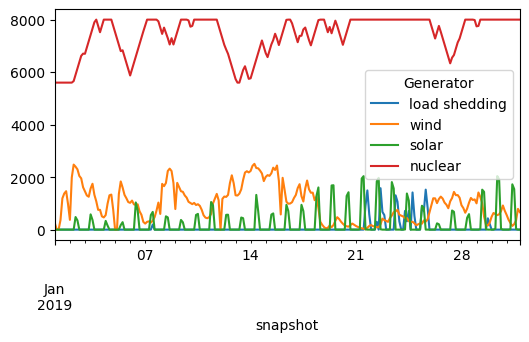

In [45]:
n.generators_t.p.loc["2019-01"].plot(figsize=(6, 3))